The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


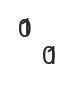

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import reconstruction_accuracy, VAELoss
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullFVAE
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# Some checks

In [50]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/args_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.txt | tail -n 10


0
Fold: 0Best valid epoch: 575
total:	0.4113215639264493
reconstruction:	0.37363986051697323
kld:	0.037681700979748246
seq_accuracy:	0.9379920959472656
v_accuracy:	0.9218271970748901
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9381558377693086
Best valid V acc: 0.9215917117965623
Best valid J acc: 0.993407110901813

1
Fold: 1Best valid epoch: 674
total:	0.6807788295862699
reconstruction:	0.6456284207852802
kld:	0.0351504118170354
seq_accuracy:	0.9561837315559387
v_accuracy:	0.8152686357498169
j_accuracy:	0.9957587122917175
Fold: 1Best valid seq acc: 0.9566856574804349
Best valid V acc: 0.819038642789821
Best valid J acc: 0.9957587181903864

2
Fold: 2Best valid epoch: 795
total:	0.7249003094413676
reconstruction:	0.6897032166819129
kld:	0.03519708667349759
seq_accuracy:	0.9577098488807678
v_accuracy:	0.8235571384429932
j_accuracy:	0.9955241680145264
Fold: 2Best valid seq acc: 0.9571465191206466
Best valid V acc: 0.8235571260306243
Best valid J acc: 0.9967020023557126

3
F

Probly don't need to have that much weight on J gene but for V gene 2.5 seems good.

In [33]:
%ls ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.csv


In [27]:
# init stuff
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
# Re-init / write down params here ; Taken from the args.txt
max_len, encoding, pad_scale = 23, 'BL50LO', -20
cdr3b_col, v_col, j_col = 'B3', 'TRBV_gene', 'TRBJ_gene'
use_v, use_j, v_dim, j_dim = True, True, 51, 13
hidden_dim, latent_dim = 256, 128
lr, weight_decay = 5e-4, 1e-4
loss_weights = {'weight_seq':3, 'weight_kld':1, 'weight_v':2.5, 'weight_j':2}
n_epochs, batch_size = 2000, 256
# Remaking dataset-loaders
total_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map=None, j_map = None)
total_loader = total_dataset.get_dataloader(batch_size, RandomSampler)
test_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map= total_dataset.v_map, j_map = total_dataset.j_map)
test_loader = test_dataset.get_dataloader(batch_size, SequentialSampler)
folder = '../output/FirstTest_230926_1923_bb76k/'

In [ ]:
# Turns out, I didn't think that different partitions in the train dataset would have different v/j maps.
# As such, I need to save it here and reload it everytime (HARDCODED BAD BEHAVIOUR BUT NO WORKAROUND BECAUSE I NEED TO MAKE SURE THINGS MATCH BETWEEN FOLDS)
# Also need to fix the weights on seq/kld/v/j weights to 3, 2, 2.5, 1.5 ; For now, re-run the scripts and test stuff here and do inference.

In [44]:
pkl_dump(total_dataset.v_map, '../data/Matrices/230927_nettcr_dataset_vmap.pkl')
pkl_dump(total_dataset.j_map, '../data/Matrices/230927_nettcr_dataset_jmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_vmap.pkl saved.
/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_jmap.pkl saved.


# Reloading models and preds from KCV

In [25]:
len(kcv_df.TRBV_gene.unique())

51

In [45]:
models = {}
for i in range(5):
    fn = f'{folder}FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/checkpoint_best_fold{i:02}_kcv_230921_nettcr_immrepnegs_noswap_f{i:02}_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.pt'
    try:
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
    except:
        print(i)
        d = torch.load(fn)
        print(d['encoder.0.weight'].shape)
    # might as well retrain all folds with adjusted v/j/kld weights

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
0
torch.Size([261, 523])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
3
torch.Size([261, 523])


# inference using the reloaded models (missing 2 folds) 230927_1009

In [ ]:
from sklearn.metrics import hamming_loss
def get_real_acc(hat, true):
    hat = hat.split('X')[0]
    true = true.split('X')[0]
    return hamming_loss(true, hat

In [67]:
from sklearn.metrics import hamming_loss
hat = 'ASRYRKSGGNTIYXXXXXXXXXX'.split('X')[0]
true = 'ASRYRQSGGNTIYXXXXXXXXXX'.split('X')[0]

In [58]:
models.keys()

dict_keys([1, 2, 4])

In [52]:
%ls {folder}/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.txt
checkpoint_best_fold01_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.csv


In [56]:
z_valid_1 = pd.read_csv(f'{folder}FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.csv')
z_test_1 = predict_model(models[1], test_dataset, test_loader)

In [60]:
z_valid_2 = pd.read_csv(f'{folder}FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f02_FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k.csv')
z_test_2 = predict_model(models[2], test_dataset, test_loader)

In [61]:
z_valid_4 = pd.read_csv(f'{folder}FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.csv')
z_test_4 = predict_model(models[4], test_dataset, test_loader)

In [72]:
sample = test_dataset.x[:5]
x_hat, _, _ = models[1](sample)


In [129]:
# Redo accuracy without padding
seq_true, v_true, j_true = models[1].reconstruct_hat(sample)
seq_hat, v_hat, j_hat = models[1].reconstruct_hat(x_hat)
# randomly change some indices so acc is not 100%
seq_hat[0,5:7]=3
seq_hat[1,6]=12
seq_hat[2, 0:7]=4

In [143]:
# NOTE : Fixed version with the true acc
def redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, pad_index=20, return_per_element=False):

    mask = (seq_true != pad_index).float()
    true_lens = mask.sum(dim=1)
    # masked_seq_true = seq_true*mask
    # masked_seq_hat = seq_hat*mask
    # difference here for per element is that we don't take the mean(dim=0) and have to detach() from graph to do tolist()
    seq_accuracy = ((seq_true == seq_hat).float() * mask).sum(1) / true_lens
    print(true_lens)
    print(mask)
    if return_per_element:
        seq_accuracy = seq_accuracy.detach().cpu().tolist()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
    else:
        seq_accuracy = seq_accuracy.mean(dim=0).item()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float().mean(dim=0)).item()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float().mean(dim=0)).item()
    return seq_accuracy, v_accuracy, j_accuracy
redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, 20, True)[0]

tensor([10., 12., 13., 13., 13.])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])


[0.800000011920929, 0.9166666865348816, 0.38461539149284363, 1.0, 1.0]

In [109]:
((seq_true==seq_hat).float() * mask).sum(1) / true_lengths

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [107]:
# Create a binary mask where 1 indicates non-padding values
mask = (seq_true != 20).float()

# Sum along the columns to get the true length for each row
true_lengths = mask.sum(dim=1)
# Apply the mask to both seq_true and seq_hat
masked_seq_true = seq_true * mask
masked_seq_hat = seq_hat * mask

# Calculate element-wise equality
reconstruction_accuracy = ((masked_seq_true == masked_seq_hat).float() * mask).sum(1) / true_lengths
reconstruction_accuracy

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [97]:
true_lengths

tensor([10., 12., 13., 13., 13.])